# Look into relationship between rides and weather data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3

In [2]:
con1 = sqlite3.connect('data/citibike_database.db3')
con2 = sqlite3.connect('data/nyc_weather.db3')

In [3]:
rides = pd.read_sql_query("SELECT yday,count(*) as num_rides FROM rides WHERE year=2015 GROUP BY yday",con1)
rides.head()

,yday,num_rides
0,1,5317
1,2,11304
2,3,4478
3,4,7849
4,5,14506


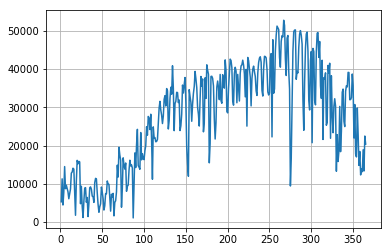

In [4]:
plt.plot(rides.yday, rides.num_rides)
plt.grid();

In [5]:
wea = pd.read_sql_query("SELECT * FROM temps WHERE year=2015",con2)
wea.head()


,date,st_code,Max_TemperatureF,Min_TemperatureF,Mean_TemperatureF,year,yday,month
0,2015-01-01 00:00:00,KLGA,39,27,33,2015,1,1
1,2015-01-02 00:00:00,KLGA,42,35,39,2015,2,1
2,2015-01-03 00:00:00,KLGA,41,31,36,2015,3,1
3,2015-01-04 00:00:00,KLGA,57,41,49,2015,4,1
4,2015-01-05 00:00:00,KLGA,50,22,36,2015,5,1


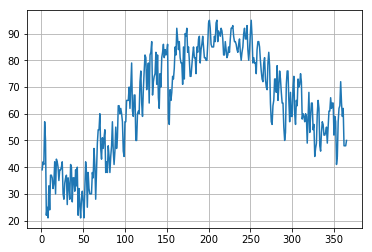

In [6]:
plt.plot(wea.yday, wea.Max_TemperatureF)
plt.grid();

Now join weather data to rides so we can plot # rides vs temperature for each day

In [7]:
comb = pd.merge(rides,wea,on='yday')
comb.head()

,yday,num_rides,date,st_code,Max_TemperatureF,Min_TemperatureF,Mean_TemperatureF,year,month
0,1,5317,2015-01-01 00:00:00,KLGA,39,27,33,2015,1
1,2,11304,2015-01-02 00:00:00,KLGA,42,35,39,2015,1
2,3,4478,2015-01-03 00:00:00,KLGA,41,31,36,2015,1
3,4,7849,2015-01-04 00:00:00,KLGA,57,41,49,2015,1
4,5,14506,2015-01-05 00:00:00,KLGA,50,22,36,2015,1


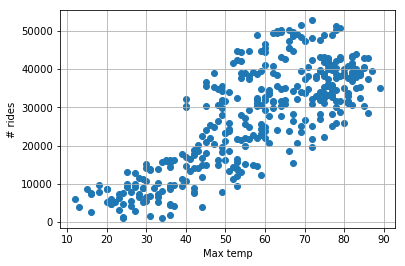

In [8]:
#plt.scatter(comb.Max_TemperatureF,comb.num_rides)
plt.scatter(comb.Mean_TemperatureF,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')

## Fit a linear regression using statsmodels

In [9]:
# Fit a linear regression
import statsmodels.formula.api as smf
# create a fitted model in one line
lm = smf.ols(formula='num_rides ~Mean_TemperatureF', data=comb).fit()
# print the coefficients
lm.params

Intercept           -4916.695259
Mean_TemperatureF     564.065518
dtype: float64

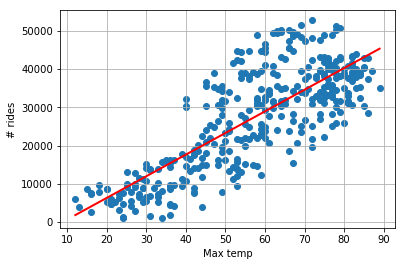

In [10]:
# plot the regression line over the data
X_new = pd.DataFrame({'Mean_TemperatureF': [comb.Mean_TemperatureF.min(), comb.Mean_TemperatureF.max()]})
X_new.head()
preds = lm.predict(X_new)
#preds
plt.scatter(comb.Mean_TemperatureF,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')

plt.plot(X_new,preds,c='red',linewidth=2)

The R^2 value is 0.62, which means that 62% of the variance in num_rides can be explained by the mean temperature.

In [11]:
lm.rsquared

0.62470586686050456

## Fit linear regression w/ sklearn

In [15]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
X = comb.Mean_TemperatureF.values.reshape(-1,1)
Y = comb.num_rides.values.reshape(-1,1)
reg.fit(X,Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

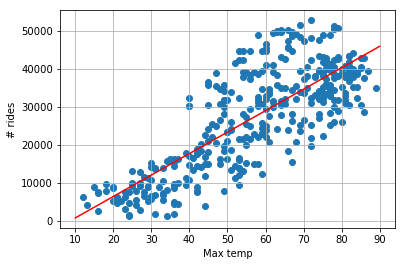

In [35]:
plt.scatter(comb.Mean_TemperatureF,comb.num_rides)
plt.grid();
plt.xlabel('Max temp')
plt.ylabel('# rides')
pred_X = np.array([10,90]).reshape(-1,1)
plt.plot(pred_X,reg.predict(pred_X),c='red')

In [38]:
reg.score(X,Y)

0.62470586686050467